Code used to sanity-check data: plotting raw and written files, calculating various statistics

# Plot NCAR Raw data

In [1]:
import zarr
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import os

In [2]:
# %matplotlib widget

In [3]:
# raw_ncar_folder_path = '/home/idies/workspace/turb/data02_02/ncar-low-rate-fixed-dt/'
raw_ncar_folder_path = '/home/idies/workspace/turbulence-ceph-staging/ncar-jhf/lr'
save_folder_path = '/home/idies/workspace/Storage/ariel4/persistent/ncar-zarr-code/zarr_reading/visualizations/'

chunk_size=64


var = 'e'
variable = var

# timestep_range = range(5) # This will definitely crash the Kernel
timestep_nr = 0

In [13]:
# needed for sciserver jobs
%cd /home/idies/workspace/Storage/ariel4/persistent/zarrify-across-network

/home/idies/workspace/Storage/ariel4/persistent/zarrify-across-network


In [14]:
# for timestep_nr in timestep_range:
#     data = xr.open_dataset(raw_ncar_folder_path + "/jhd.00" + str(timestep_nr) + ".nc")


data_xr = xr.open_dataset(raw_ncar_folder_path + "/jhf." + str(timestep_nr).zfill(3) + ".nc", chunks={'nnz': chunk_size, 'nny': chunk_size, 'nnx': chunk_size})

In [15]:
steps = range(0, data_xr['t'].shape[2], 10)

# for i, z in enumerate(z_steps):
#     print(i,z)

### Runtimes

3min 45s +- 4min(!) to load Array `np.array(data[var])`

33.3s to plot using in-memory numpy array (from above)

14min 17s +- 6min for loading data using `data_xr[var][slice]` every time

Skipping the np.array loading takes wayyy too long (>1h for 7 runs atm)

<font color="red">Use np.array(data_xr['e'].isel(nnz=z_indices, nny=slice(None), nnx=slice(None)))!! Only 15sec!</font>

In [16]:
# TODO make this into a function

z_indices = [0]
x_indices = [0]
# z_indices = [2047]
z = 0

# Change this to slice along a different axis
# slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(None), nnx=slice(None)))
# Load only 512x512
# slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(0, 512), nnx=slice(0, 512)))
slice_data = np.array(data_xr[var].isel(nnz=slice(0, 512), nny=slice(0, 512), nnx=z_indices))

slice_data = np.squeeze(slice_data)

In [17]:
slice_data.shape

(512, 512)

In [ ]:
# slice_data = slice_data[:512, :512]

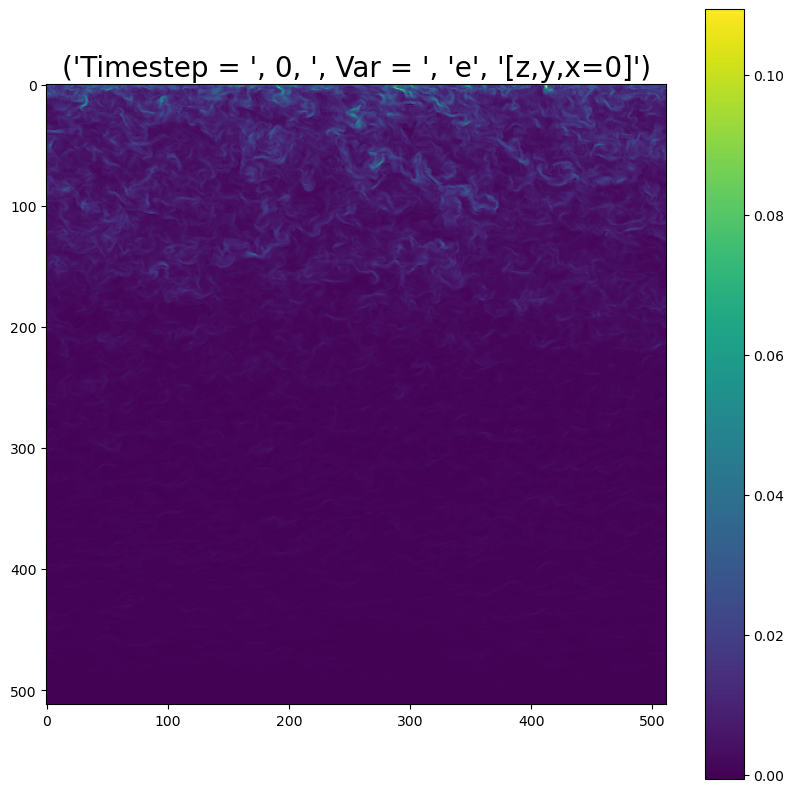

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(slice_data)#, cmap='gist_gray')#, vmin=-.5, vmax=.6)

#     name = "[z,y=" +str(y) + ",x]" # y
# name = "Timestep = ", timestep_nr, ", Var = ", var, "[z=" +str(z) + ",y,x]" # z
name = "Timestep = ", timestep_nr, ", Var = ", var, "[z,y,x=" +str(z) + "]" # x

plt.title(name, fontsize=20)
plt.colorbar()

# Save figures to disk
# plt.savefig(f'visualizations/timestep_' + str(timestep_nr) + '/' + var + "/" + name + '.png')
# plt.close()

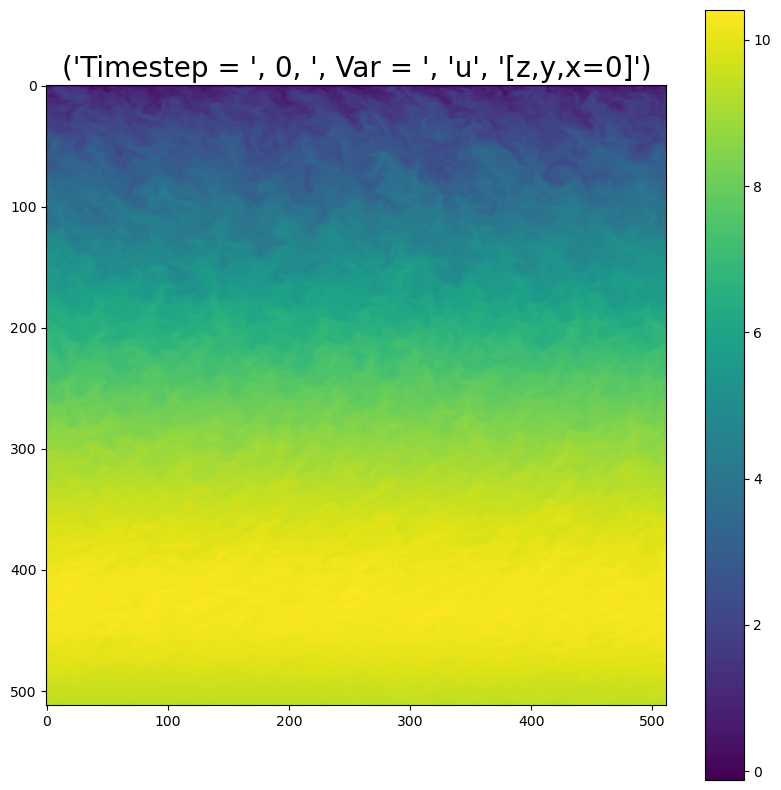

In [20]:
# TODO make this into a function
var = 'u'

z_indices = [0]
x_indices = [0]
# z_indices = [2047]
z = 0

# Change this to slice along a different axis
# slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(None), nnx=slice(None)))
# Load only 512x512
# slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(0, 512), nnx=slice(0, 512)))
slice_data = np.array(data_xr[var].isel(nnz=slice(0, 512), nny=slice(0, 512), nnx=z_indices))

slice_data = np.squeeze(slice_data)


plt.figure(figsize=(10,10))
plt.imshow(slice_data)#, cmap='gist_gray')#, vmin=-.5, vmax=.6)

#     name = "[z,y=" +str(y) + ",x]" # y
# name = "Timestep = ", timestep_nr, ", Var = ", var, "[z=" +str(z) + ",y,x]" # z
name = "Timestep = ", timestep_nr, ", Var = ", var, "[z,y,x=" +str(z) + "]" # x

plt.title(name, fontsize=20)
plt.colorbar()

# Save figures to disk
# plt.savefig(f'visualizations/timestep_' + str(timestep_nr) + '/' + var + "/" + name + '.png')
# plt.close()

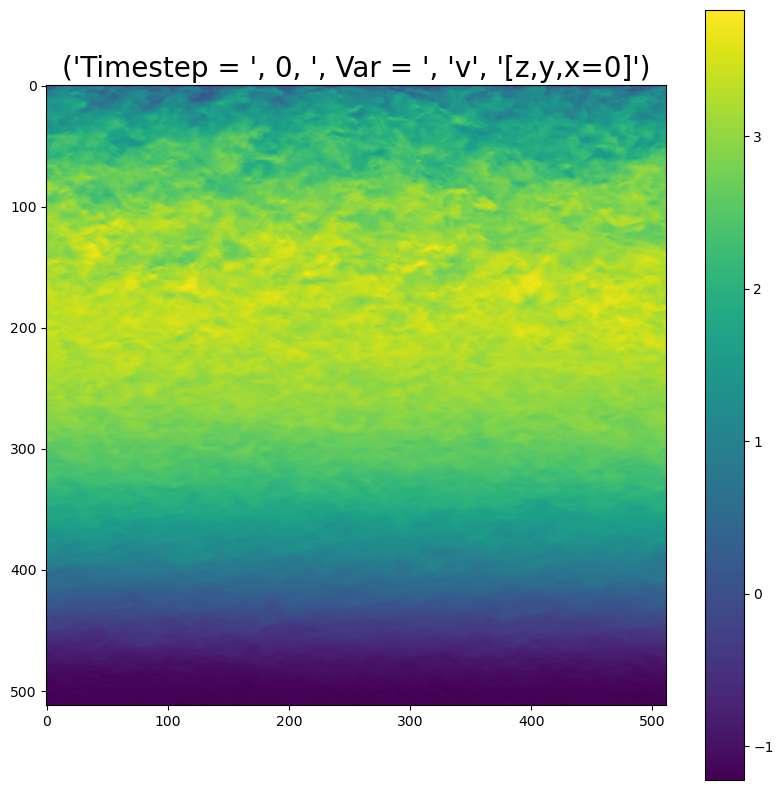

In [21]:
# TODO make this into a function
var = 'v'

z_indices = [0]
x_indices = [0]
# z_indices = [2047]
z = 0

# Change this to slice along a different axis
# slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(None), nnx=slice(None)))
# Load only 512x512
# slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(0, 512), nnx=slice(0, 512)))
slice_data = np.array(data_xr[var].isel(nnz=slice(0, 512), nny=slice(0, 512), nnx=z_indices))

slice_data = np.squeeze(slice_data)


plt.figure(figsize=(10,10))
plt.imshow(slice_data)#, cmap='gist_gray')#, vmin=-.5, vmax=.6)

#     name = "[z,y=" +str(y) + ",x]" # y
# name = "Timestep = ", timestep_nr, ", Var = ", var, "[z=" +str(z) + ",y,x]" # z
name = "Timestep = ", timestep_nr, ", Var = ", var, "[z,y,x=" +str(z) + "]" # x

plt.title(name, fontsize=20)
plt.colorbar()

# Save figures to disk
# plt.savefig(f'visualizations/timestep_' + str(timestep_nr) + '/' + var + "/" + name + '.png')
# plt.close()

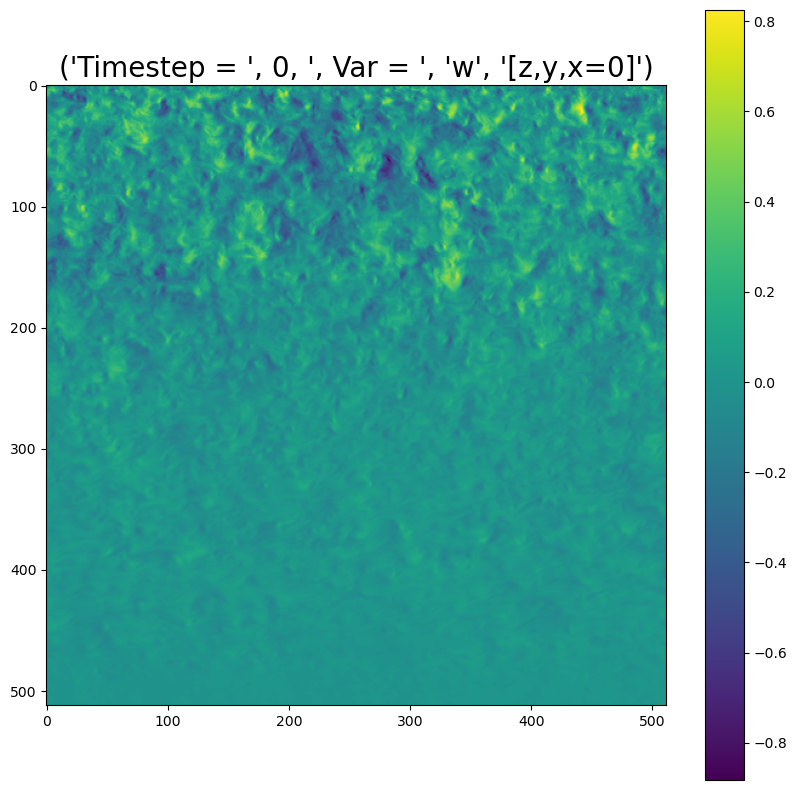

In [22]:
# TODO make this into a function
var = 'w'

z_indices = [0]
x_indices = [0]
# z_indices = [2047]
z = 0

# Change this to slice along a different axis
# slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(None), nnx=slice(None)))
# Load only 512x512
# slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(0, 512), nnx=slice(0, 512)))
slice_data = np.array(data_xr[var].isel(nnz=slice(0, 512), nny=slice(0, 512), nnx=z_indices))

slice_data = np.squeeze(slice_data)


plt.figure(figsize=(10,10))
plt.imshow(slice_data)#, cmap='gist_gray')#, vmin=-.5, vmax=.6)

#     name = "[z,y=" +str(y) + ",x]" # y
# name = "Timestep = ", timestep_nr, ", Var = ", var, "[z=" +str(z) + ",y,x]" # z
name = "Timestep = ", timestep_nr, ", Var = ", var, "[z,y,x=" +str(z) + "]" # x

plt.title(name, fontsize=20)
plt.colorbar()

# Save figures to disk
# plt.savefig(f'visualizations/timestep_' + str(timestep_nr) + '/' + var + "/" + name + '.png')
# plt.close()

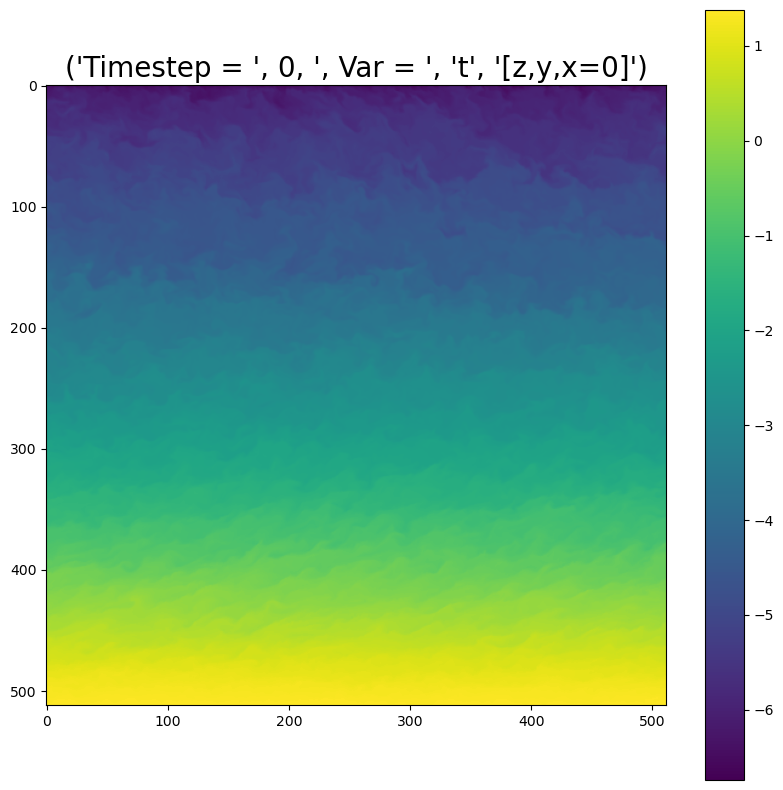

In [23]:
# TODO make this into a function
var = 't'

z_indices = [0]
x_indices = [0]
# z_indices = [2047]
z = 0

# Change this to slice along a different axis
# slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(None), nnx=slice(None)))
# Load only 512x512
# slice_data = np.array(data_xr[var].isel(nnz=z_indices, nny=slice(0, 512), nnx=slice(0, 512)))
slice_data = np.array(data_xr[var].isel(nnz=slice(0, 512), nny=slice(0, 512), nnx=z_indices))

slice_data = np.squeeze(slice_data)


plt.figure(figsize=(10,10))
plt.imshow(slice_data)#, cmap='gist_gray')#, vmin=-.5, vmax=.6)

#     name = "[z,y=" +str(y) + ",x]" # y
# name = "Timestep = ", timestep_nr, ", Var = ", var, "[z=" +str(z) + ",y,x]" # z
name = "Timestep = ", timestep_nr, ", Var = ", var, "[z,y,x=" +str(z) + "]" # x

plt.title(name, fontsize=20)
plt.colorbar()

# Save figures to disk
# plt.savefig(f'visualizations/timestep_' + str(timestep_nr) + '/' + var + "/" + name + '.png')
# plt.close()

# Plot Zarr Written data

## Newer NCAR StSABL (jhf)

In [10]:
stored_jhf_path = "/home/idies/workspace/turbulence-ceph-staging/sciserver-turbulence/stsabl2048low/stsabl2048low.zarr"
raw_jhf_0_path = "/home/idies/workspace/turbulence-ceph-staging/ncar-jhf/lr/jhf.000.nc"

In [12]:
import zarr
import xarray as xr

ds = zarr.open(stored_jhf_path)
original_ds = xr.open_dataset(raw_jhf_0_path)

pressure_data = ds['pressure']

In [13]:
original_ds.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (nnz: 2048, nny: 2048, nnx: 2048)
Dimensions without coordinates: nnz, nny, nnx
Data variables:
    u        (nnz, nny, nnx) float32 ...
    v        (nnz, nny, nnx) float32 ...
    w        (nnz, nny, nnx) float32 ...
    t        (nnz, nny, nnx) float32 ...
    p        (nnz, nny, nnx) float32 ...
    e        (nnz, nny, nnx) float32 ...
Attributes:
    Simulation conducted by:  Edward Patton, patton@ucar.edu
    Dataset built by:         Edward Patton, patton@ucar.edu
    Affiliation:              NCAR/MMM
    Code:                     NCAR-LES
    Case Description:         GABLS 1, Cooling Rate: 1.00 K/hr
    Created:                  2024-09-10 16:40:54 -0600 UTC>

In [3]:
ds.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,4
No. arrays,4
No. groups,0
Arrays,"energy, pressure, temperature, velocity"


In [16]:
ds['velocity'].info

Name,/velocity
Type,zarr.core.Array
Data type,float32
Shape,"(20, 2048, 2048, 2048, 3)"
Chunk shape,"(1, 64, 64, 64, 3)"
Order,C
Read-only,False
Compressor,None
Store type,zarr.storage.DirectoryStore
No. bytes,2061584302080 (1.9T)
No. bytes stored,328


In [15]:
ds.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,4
No. arrays,4
No. groups,0
Arrays,"energy, pressure, temperature, velocity"


In [10]:
ds['energy'].shape

(20, 2048, 2048, 2048, 1)

### Data Statistics

In [56]:
ds['temperature'].shape

(20, 2048, 2048, 2048, 1)

In [60]:
full_t0_temp = ds['temperature'][0,:,:,:,0]

In [61]:
full_t0_temp.shape

(2048, 2048, 2048)

In [63]:
xy_means = []

for i in range(0, 2048, 50):
    xy_means.append(full_t0_temp[:,:,i].mean())

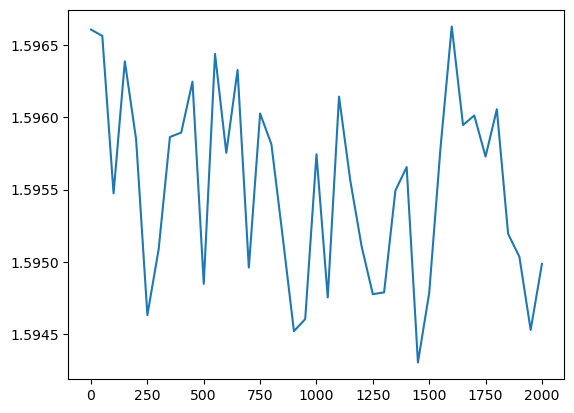

In [64]:
from matplotlib import pyplot as plt

plt.plot(list(range(0, ds['temperature'].shape[1], 50)), xy_means)

Text(0, 0.5, 'Average Temperature')

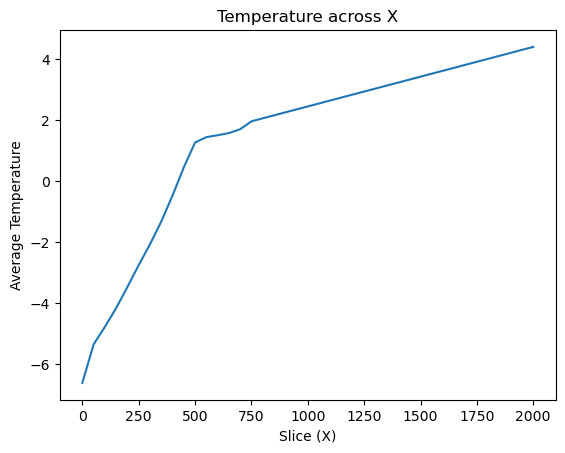

In [66]:
yz_means = []

for i in range(0, 2048, 50):
    yz_means.append(full_t0_temp[i,:,:].mean())


plt.plot(list(range(0, 2048, 50)), yz_means)
plt.title("Temperature across X")
plt.xlabel("Slice (X)")
plt.ylabel("Average Temperature")

### Slice Plotting

This can take a few minutes

In [36]:
plt.rcParams['image.cmap'] = 'inferno'

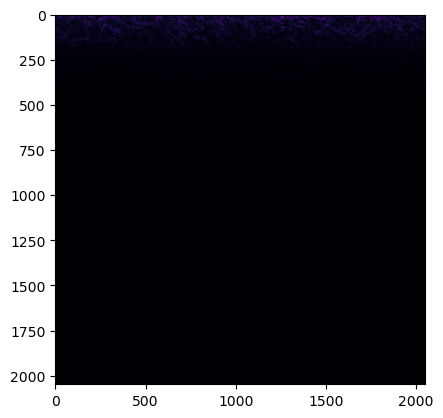

In [37]:
from matplotlib import pyplot as plt

plt.imshow(ds['energy'][0,:,:, 0, 0])

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(ds['energy'][0,:,:, 1024, 0])

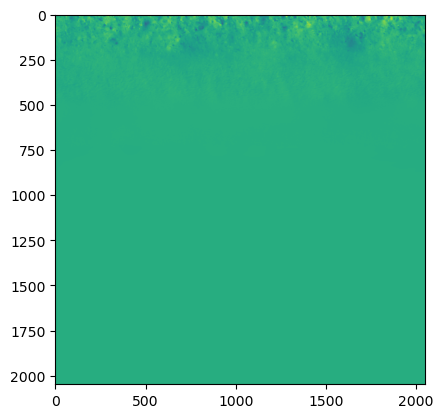

In [14]:
from matplotlib import pyplot as plt

plt.imshow(ds['pressure'][0,:,:, 0, 0])

In [47]:
ds['temperature'][0, -20:, 0, 0, 0]

array([4.4604535, 4.4624925, 4.4644995, 4.4664145, 4.4684544, 4.470438 ,
       4.472301 , 4.4741   , 4.4759045, 4.477814 , 4.4795804, 4.4812646,
       4.4829383, 4.48481  , 4.486722 , 4.488339 , 4.490284 , 4.492052 ,
       4.493502 , 4.4961696], dtype=float32)

In [53]:
# Y is correct (i.e. in-place)
print(ds['temperature'][0, 0, :, 0, 0].mean())
print(ds['temperature'][0, 0, :, 0, 0].std())

-6.6248293
0.06011537


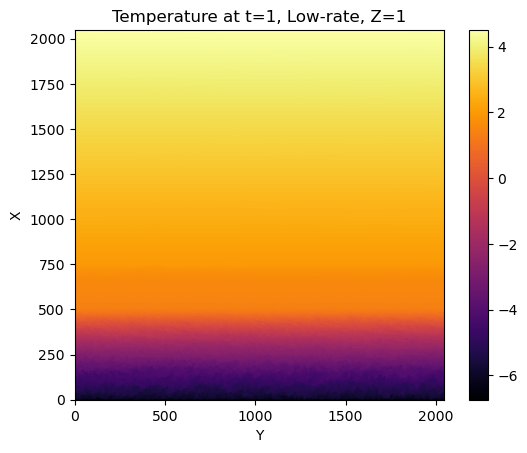

In [51]:
from matplotlib import pyplot as plt

plt.imshow(ds['temperature'][0, :, :, 0, 0], cmap="inferno")
plt.gca().invert_yaxis()  # Invert the y-axis to place 0 at the bottom

plt.title("Temperature at t=1, Low-rate, Z=1")
plt.xlabel("Y")
plt.ylabel("X")

plt.colorbar()
plt.show()

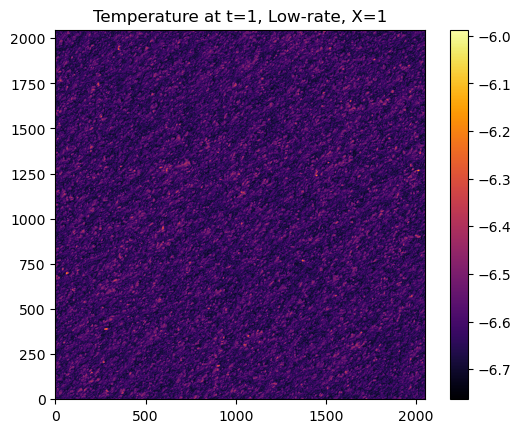

In [55]:
from matplotlib import pyplot as plt

plt.imshow(ds['temperature'][0, 0, :, :, 0], cmap="inferno")
plt.gca().invert_yaxis()  # Invert the y-axis to place 0 at the bottom

plt.title("Temperature at t=1, Low-rate, X=1")
# plt.xlabel("Y")
# plt.ylabel("X")

plt.colorbar()
plt.show()

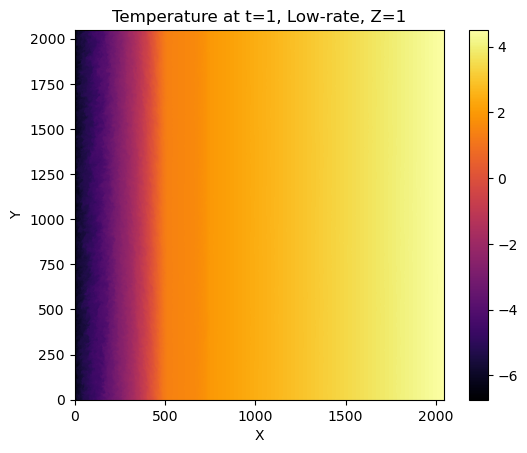

In [49]:
# Original data
plt.imshow(original_ds['t'][:, :, 0].T, cmap="inferno")
plt.gca().invert_yaxis()  # Invert the y-axis to place 0 at the bottom

plt.title("Temperature at t=1, Low-rate, Z=1")
plt.xlabel("X")
plt.ylabel("Y")

plt.colorbar()
plt.show()

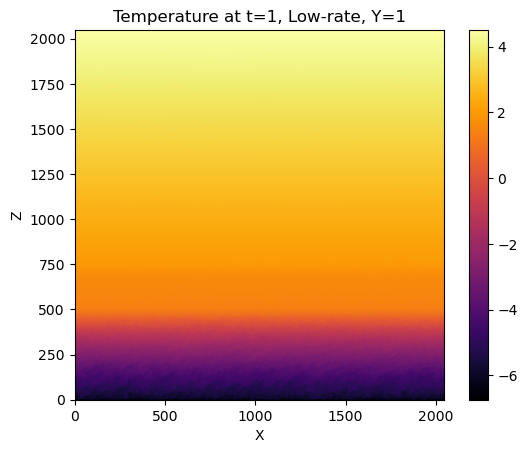

In [38]:
from matplotlib import pyplot as plt

plt.imshow(ds['temperature'][0, :, 0, :, 0], cmap="inferno")
plt.gca().invert_yaxis()  # Invert the y-axis to place 0 at the bottom

plt.title("Temperature at t=1, Low-rate, Y=1")
plt.xlabel("X")
plt.ylabel("Z")

plt.colorbar()
plt.show()

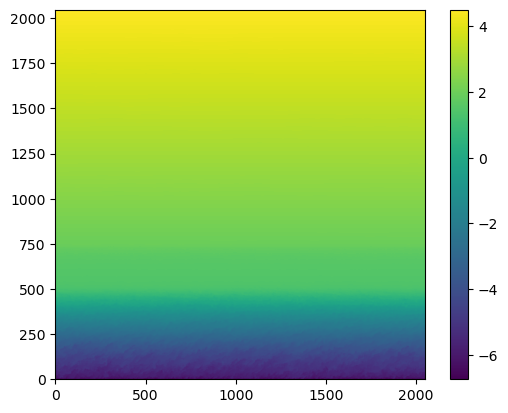

In [7]:
from matplotlib import pyplot as plt

plt.imshow(ds['temperature'][0, :, 0, :, 0])
plt.gca().invert_yaxis()  # Invert the y-axis to place 0 at the bottom
plt.colorbar()
plt.show()

### TODO plot temperature across Z (accumulate X: and Y:)

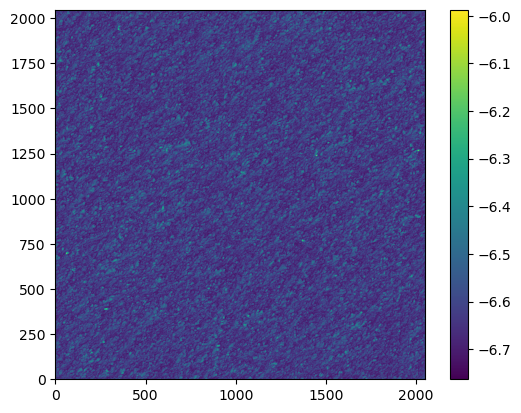

In [8]:
from matplotlib import pyplot as plt

plt.imshow(ds['temperature'][0, 0, :, :, 0])
plt.gca().invert_yaxis()  # Invert the y-axis to place 0 at the bottom
plt.colorbar()
plt.show()

In [15]:
original_ds['t'].shape

(2048, 2048, 2048)

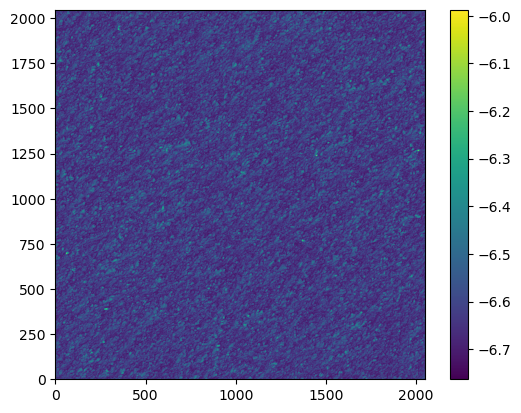

In [17]:
raw_data = original_ds['t'][0, :, :]

from matplotlib import pyplot as plt

plt.imshow(raw_data)
plt.gca().invert_yaxis()  # Invert the y-axis to place 0 at the bottom
plt.colorbar()
plt.show()

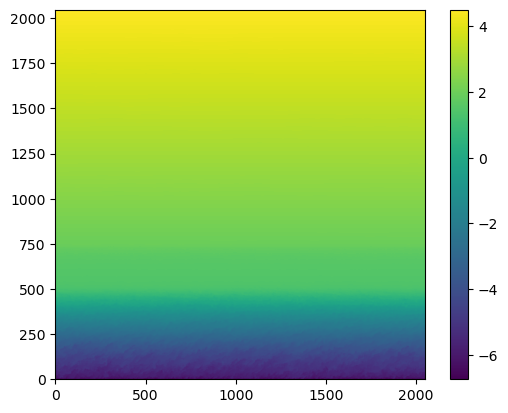

In [18]:
raw_data = original_ds['t'][:, 0, :]

from matplotlib import pyplot as plt

plt.imshow(raw_data)
plt.gca().invert_yaxis()  # Invert the y-axis to place 0 at the bottom
plt.colorbar()
plt.show()

In [25]:
import numpy as np

np.array(original_ds['t'][:10, :10, 0])

array([[-6.5814753, -6.6362877, -6.6413565, -6.598806 , -6.6029787,
        -6.653788 , -6.6594195, -6.6219215, -6.598659 , -6.5636673],
       [-6.332371 , -6.3768153, -6.410618 , -6.399134 , -6.4127593,
        -6.458226 , -6.419492 , -6.2997537, -6.2566223, -6.2897153],
       [-6.280685 , -6.3035746, -6.3196707, -6.3291626, -6.3436146,
        -6.316878 , -6.2065883, -6.09432  , -6.0714417, -6.0735874],
       [-6.27485  , -6.272231 , -6.2789392, -6.260653 , -6.2437096,
        -6.213161 , -6.1362185, -6.059914 , -6.021536 , -5.994027 ],
       [-6.2921414, -6.2659726, -6.2599134, -6.2459383, -6.2116094,
        -6.167814 , -6.1238813, -6.090043 , -6.0553756, -6.007861 ],
       [-6.282182 , -6.2587113, -6.2302327, -6.2160144, -6.1931405,
        -6.153435 , -6.12048  , -6.103981 , -6.0952563, -6.075318 ],
       [-6.255372 , -6.247637 , -6.2175236, -6.1889787, -6.1677017,
        -6.1396737, -6.114263 , -6.0986595, -6.0944986, -6.101222 ],
       [-6.216804 , -6.2154717, -6.196325

In [26]:
import numpy as np

np.array(ds['temperature'][0, :10, :10, 0, 0])

array([[-6.5814753, -6.6362877, -6.6413565, -6.598806 , -6.6029787,
        -6.653788 , -6.6594195, -6.6219215, -6.598659 , -6.5636673],
       [-6.332371 , -6.3768153, -6.410618 , -6.399134 , -6.4127593,
        -6.458226 , -6.419492 , -6.2997537, -6.2566223, -6.2897153],
       [-6.280685 , -6.3035746, -6.3196707, -6.3291626, -6.3436146,
        -6.316878 , -6.2065883, -6.09432  , -6.0714417, -6.0735874],
       [-6.27485  , -6.272231 , -6.2789392, -6.260653 , -6.2437096,
        -6.213161 , -6.1362185, -6.059914 , -6.021536 , -5.994027 ],
       [-6.2921414, -6.2659726, -6.2599134, -6.2459383, -6.2116094,
        -6.167814 , -6.1238813, -6.090043 , -6.0553756, -6.007861 ],
       [-6.282182 , -6.2587113, -6.2302327, -6.2160144, -6.1931405,
        -6.153435 , -6.12048  , -6.103981 , -6.0952563, -6.075318 ],
       [-6.255372 , -6.247637 , -6.2175236, -6.1889787, -6.1677017,
        -6.1396737, -6.114263 , -6.0986595, -6.0944986, -6.101222 ],
       [-6.216804 , -6.2154717, -6.196325

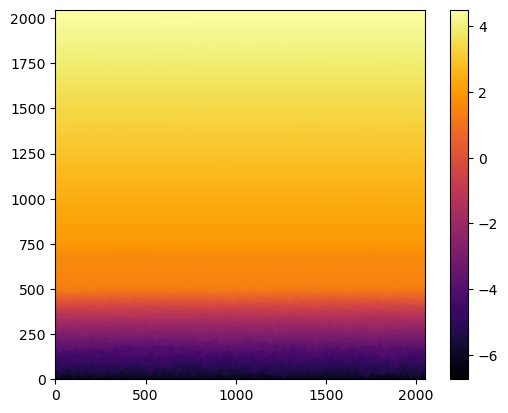

In [28]:
raw_data = original_ds['t'][:, :, 0]

from matplotlib import pyplot as plt

plt.imshow(raw_data, cmap=plt.cm.inferno)
plt.gca().invert_yaxis()  # Invert the y-axis to place 0 at the bottom
plt.colorbar()
# TODO make figure bigger
# TODO velocity near ground is 0, so need to "Zoom in " there
plt.show()

In [18]:
ds['velocity'].shape

(20, 2048, 2048, 2048, 3)

In [22]:
ds['velocity'].info

Name,/velocity
Type,zarr.core.Array
Data type,float32
Shape,"(20, 2048, 2048, 2048, 3)"
Chunk shape,"(1, 64, 64, 64, 3)"
Order,C
Read-only,False
Compressor,None
Store type,zarr.storage.DirectoryStore
No. bytes,2061584302080 (1.9T)
No. bytes stored,328


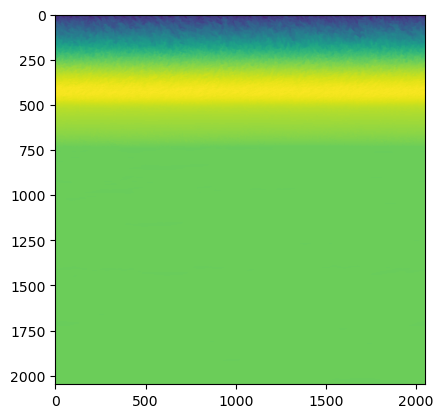

In [19]:
from matplotlib import pyplot as plt

plt.imshow(ds['velocity'][0,:,:, 0, 0])

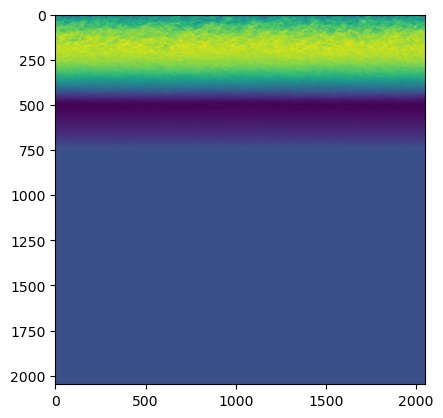

In [20]:
from matplotlib import pyplot as plt

plt.imshow(ds['velocity'][0,:,:, 0, 1])

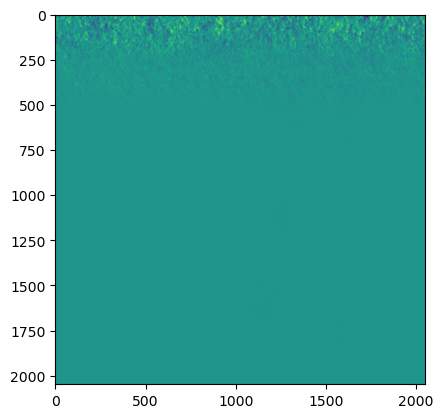

In [21]:
from matplotlib import pyplot as plt

plt.imshow(ds['velocity'][0,:,:, 0, 2])

## Original NCAR SABL (jhd)

In [ ]:
zarr_group = zarr.open_group('/home/idies/workspace/turb/data09_01/zarr/sabl2048b_09_prod/sabl2048b09_000.zarr', mode='r')
zarr_group.info

In [ ]:
zarr_xr = xr.open_zarr('/home/idies/workspace/turb/data09_01/zarr/sabl2048b_09_prod/sabl2048b09_000.zarr')

In [ ]:
slice_data = np.array(zarr_xr[variable].isel(nnz=z_indices, nny=slice(0, 512), nnx=slice(0, 512)))
slice_data = np.squeeze(slice_data)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(slice_data)#, cmap='gist_gray')#, vmin=-.5, vmax=.6)

#     name = "[z,y,x=" + str(x) + "]" # x
#     name = "[z,y=" +str(y) + ",x]" # y
name = "Timestep = ", timestep_nr, ", Var = ", var, "[z=" +str(z) + ",y,x]" # z

plt.title(name, fontsize=20)

# Save figures to disk
# plt.savefig(f'visualizations/timestep_' + str(timestep_nr) + '/' + var + "/" + name + '.png')
# plt.close()

### Plot both using Zarrify-Across-Network, to make chunk matching between original and zarr easy

For this, use Mike's getCutout